# **Fuzzy Wuzzy Product SKU Classification**

## **Install Depedencies**

In [ ]:
# Install Model Depedencies
!pip install fuzzywuzzy
!pip install tqdm

# Model & Pipeline Depedencies
!pip install mlflow
!pip install scikit-learn
!pip install apyori

# Visualiztion Depedencies
!pip install sweetviz
!pip install dataprep
!pip install wget

# Output dependies
!pip install gspread oauth2client
!pip install gspread df2gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=37f49283473f4abc5d24163dcfb4bee6414a71b75d90adc9ad0ae5e6c2afa61d
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori
     ━━━━━━━━━━━━━━━━━━━━

## **Import Depedencies**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## **Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the first dataset (text data) and convert all columns to strings
text_data_df = pd.read_excel('/content/drive/MyDrive/Data Science Weekend/Dataset/Product Name from PoS Transactions.xlsx')
text_data_df = text_data_df.applymap(str)

# Load the second dataset (class data) and convert all columns to strings
class_data_df = pd.read_excel('/content/drive/MyDrive/Data Science Weekend/Dataset/Product Catalog.xlsx')
class_data_df = class_data_df.applymap(str)

In [ ]:
text_data_df.head()

,Product Name
0,Pupuk Urea N 46%
1,Pupuk Amonium Sulfat ZA
2,Pupuk Super Fosfat SP-36
3,Pupuk NPK Phonska
4,Pupuk NPK Formula Khusus


In [ ]:
class_data_df.head()

,Product SKU,Brand,Type,Formula
0,Urea Petro,PIHC,Urea,nan
1,Urea PIM,PIHC,Urea,nan
2,Urea Nitrea,PIHC,Urea,nan
3,Urea Daun Buah,PIHC,Urea,nan
4,Urea Pusri,PIHC,Urea,nan


In [ ]:
# Lower case features
text_data_df.columns = text_data_df.columns.str.lower()
class_data_df.columns = class_data_df.columns.str.lower()

## **Import Fuzzy Wuzzy Model**

In [ ]:
from tqdm import tqdm
import pandas as pd
from fuzzywuzzy import fuzz
from tqdm import tqdm
import re

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Create a list to store the results
results = []

# Function to clean text by removing symbols and non-alphanumeric characters and convert to lowercase
def clean_text(text):
    if isinstance(text, str):  # Check if it's a string
        # Use regular expressions to remove symbols and non-alphanumeric characters
        cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return cleaned_text.lower()  # Convert to lowercase
    else:
        return text  # Return the original value if it's not a string

# Clean the text in the text_data_df DataFrame
text_data_df['cleaned_text'] = text_data_df['product name'].apply(clean_text)

# Function to propose a new product SKU if similarity is below 50
def propose_new_sku(text, class_data_df):
    max_similarity = 0
    predicted_class = ""

    # Compare the cleaned text with each class in the second dataset
    for _, class_row in class_data_df.iterrows():
        class_label = class_row['product sku'].lower()  # Convert class label to lowercase
        similarity = fuzz.ratio(text, class_label)

        # Update if a higher similarity is found
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_class = class_label

    if max_similarity < 50:
        return "New Product SKU"  # Propose a new SKU
    else:
        return predicted_class

# Loop through each text in the first dataset with a progress bar
for index, row in tqdm(text_data_df.iterrows(), total=len(text_data_df), desc="Processing"):
    text = row['cleaned_text']
    predicted_class = propose_new_sku(text, class_data_df)

    # Append the result to the list
    results.append({'Text': row['product name'],
                    'Predicted Class': predicted_class,
                    'Similarity': fuzz.ratio(text, predicted_class),
                    'Cluster':None,
                    'Model':'Fuzzy Wuzzy'})

# Create a new DataFrame from the results list
output_df = pd.DataFrame(results)

# Save the new dataset to an Excel file
# output_df.to_excel('output_dataset_class.xlsx', index=False)

Processing: 100%|██████████| 44002/44002 [21:06<00:00, 34.74it/s]


In [ ]:
output_df.head(10)

,Text,Predicted Class,Similarity,Cluster,Model
0,Pupuk Urea N 46%,New Product SKU,13,None,Fuzzy Wuzzy
1,Pupuk Amonium Sulfat ZA,ammonium sulfate,72,None,Fuzzy Wuzzy
2,Pupuk Super Fosfat SP-36,triple super phospate (tsp),60,None,Fuzzy Wuzzy
3,Pupuk NPK Phonska,New Product SKU,12,None,Fuzzy Wuzzy
4,Pupuk NPK Formula Khusus,New Product SKU,10,None,Fuzzy Wuzzy
5,Pupuk Organik Granul,New Product SKU,11,None,Fuzzy Wuzzy
6,Pupuk Organik Cair,New Product SKU,12,None,Fuzzy Wuzzy
7,Produk Lain,New Product SKU,38,None,Fuzzy Wuzzy
8,Rondap,New Product SKU,29,None,Fuzzy Wuzzy
9,Sekor,New Product SKU,20,None,Fuzzy Wuzzy


In [ ]:
low_similirity_df = output_df[output_df['Similarity'] < 50]

In [ ]:
low_similirity_df

,Text,Predicted Class,Similarity,Cluster,Model
0,Pupuk Urea N 46%,New Product SKU,13,None,Fuzzy Wuzzy
3,Pupuk NPK Phonska,New Product SKU,12,None,Fuzzy Wuzzy
4,Pupuk NPK Formula Khusus,New Product SKU,10,None,Fuzzy Wuzzy
5,Pupuk Organik Granul,New Product SKU,11,None,Fuzzy Wuzzy
6,Pupuk Organik Cair,New Product SKU,12,None,Fuzzy Wuzzy
...,...,...,...,...,...
43997,Extra one 680 EC @ 250 ml,New Product SKU,15,None,Fuzzy Wuzzy
43998,Extra One 680 SC @ 500 ml,New Product SKU,15,None,Fuzzy Wuzzy
43999,JARING ARWANA @ 100 METER,New Product SKU,10,None,Fuzzy Wuzzy
44000,Terong Puma F1 @ 5 gram,New Product SKU,22,None,Fuzzy Wuzzy


## **Clustering Product POS Transaction**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

## **Cleaning Text Function**

In [ ]:
# Step 2: Filter data with Similarity < 50
low_similarity_df = output_df[output_df['Similarity'] < 50]

# Extract the product names from the filtered data and remove missing values
product_names = low_similarity_df['Text'].dropna().tolist()

In [ ]:
import re

def clean_text(text, stopwords=['kg','ltr', 'liter', 'ml','mil',
                                'gr', 'l', 'gram', 'lt',
                                'merah', 'putih', 'besar', 'gold',
                                'roundup', 'biru', 'hijau', 'kuning',
                                'kecil', 'cair', 'biasa', 'plus', 'panjang',
                                'super', 'score', 'cap', 'eceran', 'daun', 'hitam',
                                'sp', 'up', 'top', 'dgw', 'cm', 'prima', 'mll','nk',
                                'em', 'pertiwi', 'ns', 'premium', 'power','bubuk','grm'
                                ]):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove symbols and non-alphanumeric characters
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove double spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove stopwords
        words = text.split()
        filtered_words = [word for word in words if word not in stopwords]
        clean_text = ' '.join(filtered_words)

        return clean_text
    else:
        return ""


# Function to drop empty row and row that contain only 1 character
def drop_single_character_and_empty_rows(df):
    # Drop rows with only one character in any column
    df = df[df.apply(lambda x: x.astype(str).str.len() > 1).all(axis=1)]

    # Drop empty rows
    df = df.dropna()

    return df

# Extract the product names from the filtered data and clean them
product_names = low_similarity_df['Text'].apply(clean_text).tolist()

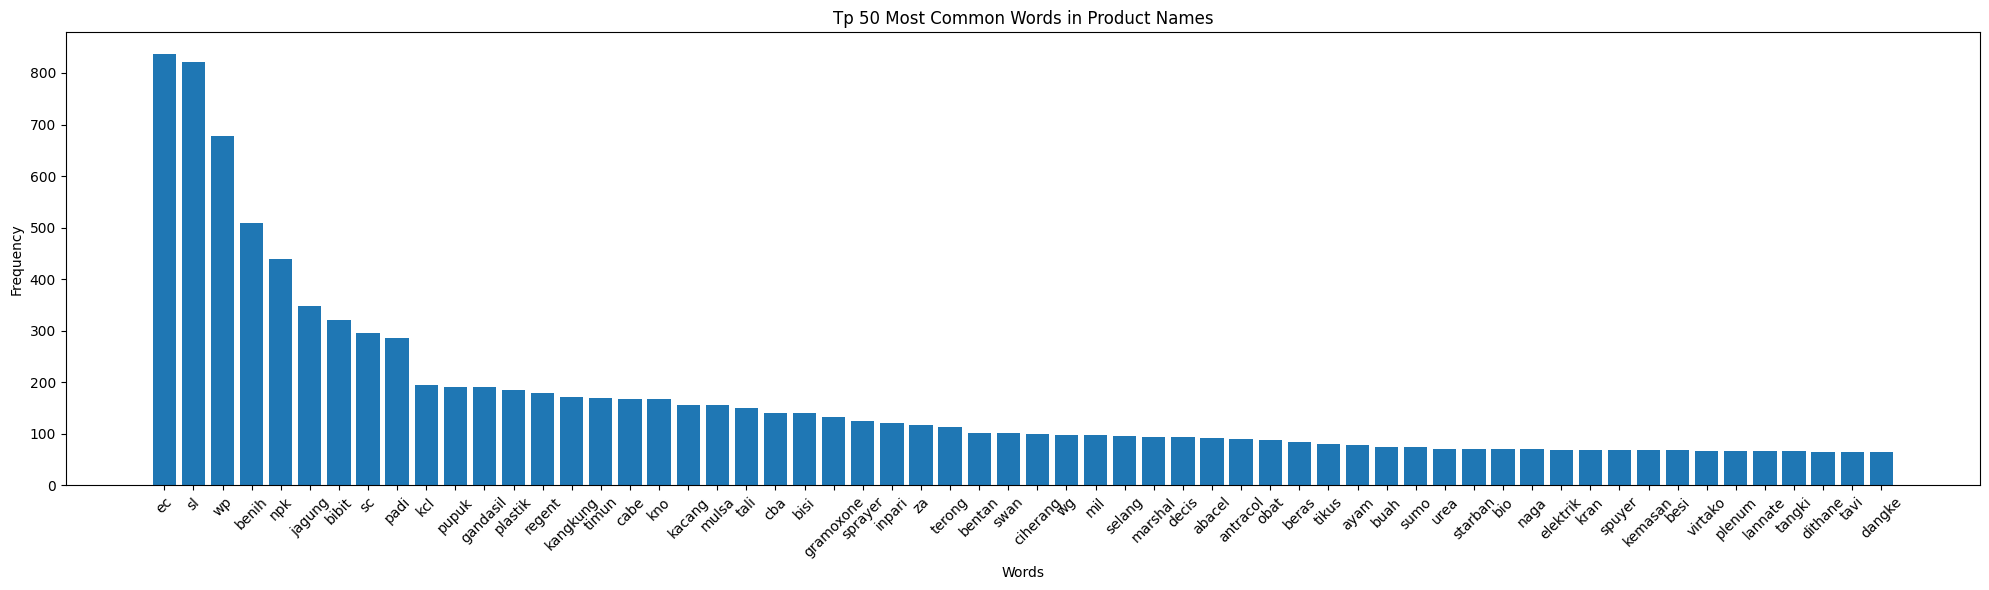

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Apply the function to the product names
cleaned_texts = [Counter(text.split()) for text in product_names]

# Combine chunk counters
total_counter = Counter()
for counter in cleaned_texts:
    total_counter.update(counter)

# Get the most common words and their counts, excluding single-character words
most_common_words = [(word, count) for word, count in total_counter.most_common() if len(word) > 1][:60]  # Customize the number of words to show

# Extract words and their counts for plotting
words, counts = zip(*most_common_words)

# Create a DataFrame from the extracted words and counts
word_count_df = pd.DataFrame({'Word': words, 'Count': counts})

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Tp 50 Most Common Words in Product Names')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show()





1.   ec - insektisida
2.   sl - herbisida
3.   wp - fungisida
4.   benih - benih tanaman
5.   npk - pupuk npk
7.   jagung - produk jagung
8.   bibit - produk bibit
10.  sc - pestisida
11.  padi - produk padi
14.  kcl - pupuk kcl
16.  pupuk - pupuk
17.  gandasil - pupuk
18.  plastik - plastik
19.  regent - insektisida
21.  kangkung - tanaman
22.  timun - tanaman
23.  cabe - tanaman
24.  kno - pupuk
25.  kacang - tanaman
26.  mulsa - plastik mulsa
28.  tali - tali
29.  cba - herisida
30.  bisi - benih
32.  gramoxone - herisida
33.  sprayer - sprayer
34.  inpari - benih
35.  za - pupuk
36.  terong - tanaman
37.  bentan - insektisida
38.  swan - sprayer
39.  ciherang - beras
40.  wg - herbisida
41.  mil - rokok
42.  selang - selang
43.  marshal - insektisida
44.  decis - insektisida
45.  abacel - insektisida
46.  antracol - fungsida
47.  obat - obat
48.  beras - beras
49.  urea - urea
50.  starban - insektisida
52.  virtako - insektisida
53.  plenum - insektisida
54.  lannate - insektisida
55.  dhitane - fungisida
56.  tavi - bibit





## **Word to Vector Process**

In [ ]:
# Step 3: Vectorize Text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(product_names)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


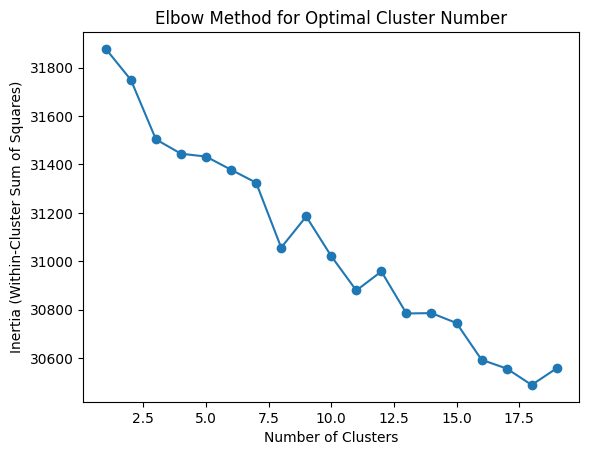

In [ ]:
# Step 4: Determine the optimal number of clusters using the elbow method
inertia = []
for num_clusters in range(1, 20):  # Try different numbers of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()

## **K-Means Model**

In [ ]:
# Based on the elbow method graph, select the optimal number of clusters
optimal_num_clusters = 16  # Adjust this based on the graph

In [ ]:
# Step 5: Perform K-Means Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)
kmeans.fit(tfidf_matrix)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


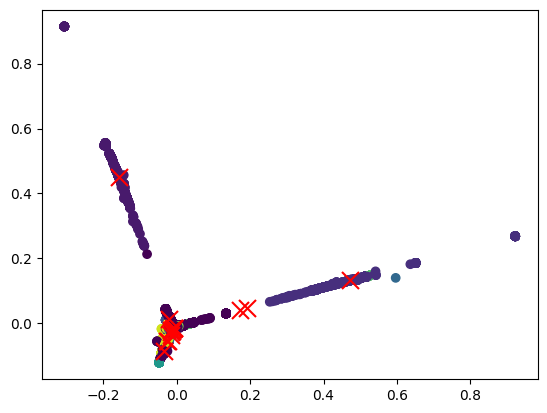

Cluster 1:
['pupuk urea n', 'pupuk organik granul', 'pupuk organik', 'produk lain', 'rondap', 'sekor', 'abacel', 'spontan', 'starban', 'gramoxon', 'combitox', 'fujiwan', 'buldok', 'starban', 'postinml', 'trebon', 'ronsha', 'sidamethrin', 'dharmasan', '', 'sidacron', 'ronsha', 'sidatan', 'slop obr', 'fostin', 'topsida', 'tebalo', 'aplaud', 'fatalkeong', 'dangke', 'denox', 'ziputkeong', 'sampurna b', 'gramoxone', 'corrtonic', 'vanesatimun', 'broadplsob jkt', 'bnih pare', 'terong', 'anti keong', 'bpmc', 'benjos', 'bigrow', 'naga', 'primaze', 'round', 'gramaxone', 'dup burung', 'mi sedap goreng', 'susu sasaet', 'indamin', 'arivo', 'bisi', 'denis', 'tugard', 'lanete', 'mod panda', 'liquid cookies', 'abacel', 'gramaxon', 'sumoml', 'antracol', 'antracol', 'antracol', 'amistartopml', 'avidor', 'atonik', 'acrobat', 'amabas', 'agrogib', 'antila', 'amotan', 'akron', 'arjuna', 'arjuna', 'agil', 'agil', 'agrimec', 'amino age', 'abacel', 'abacel', 'agus', 'agus', 'agrithane', 'alfart', 'avjunsu', 'a

In [ ]:
# Step 6: Visualize Clusters (optional)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', s=150, c='r')
plt.show()

# Print the clusters
for cluster_id in range(optimal_num_clusters):
    cluster_product_names = [product_names[i] for i, label in enumerate(labels) if label == cluster_id]
    print(f"Cluster {cluster_id + 1}:")
    print(cluster_product_names)

In [ ]:
import pandas as pd

Similarity = low_similarity_df['Similarity']

# Map cluster labels to custom cluster names
cluster_names = {0: 'Produk Lainnya',
                 1: 'Insektisida EC',
                 2: 'Insektisida/Herbisida SL',
                 3: 'Jenis Tanaman Timun',
                 4: 'Insektisida SC',
                 5: 'Pupuk NPK',
                 6: 'Kacang/Kaleng',
                 7: 'Insektisida Prevathon',
                 8: 'Moluskisida WP',
                 9: 'Pupuk Gandasil',
                 10: 'Insektisida WG',
                 11: 'Herbisida SL',
                 12: 'Herbisida Marxone SL',
                 13: 'Produk Ikan & Ayam',
                 14: 'Benih',
                 15: 'Bibit'}  # Add more as needed

# Create a DataFrame with product names, their corresponding clusters, and cluster names
cluster_data = {'Product Name': product_names,
                'Similarity':Similarity,
                'Cluster': labels,
                'Model': 'K-Means'}
df = pd.DataFrame(cluster_data)

# Add a new column for cluster names based on the mapping
df['Product Category'] = df['Cluster'].map(cluster_names)

# Save the DataFrame to an Excel file
# df.to_excel('cluster_output.xlsx', index=False)

In [ ]:
high_similarity_df = output_df[output_df['Similarity'] >= 50]

In [ ]:
# Assuming high_similirity_df is one DataFrame and you have other DataFrames like df1, df2, etc.
columns_to_select = ['Text', 'Predicted Class', 'Similarity', 'Cluster','Model']

# Selecting specific columns from high_similirity_df
df_fuzzy_output = high_similarity_df[columns_to_select]

# Change column name
df_fuzzy_output.rename(columns={'Text':'Product Name'}, inplace=True)
df_fuzzy_output.rename(columns={'Predicted Class':'Product SKU'}, inplace=True)

In [ ]:
# Assuming high_similirity_df is one DataFrame and you have other DataFrames like df1, df2, etc.
columns_to_select = ['Product Name', 'Product Category','Similarity', 'Cluster', 'Model']

# Selecting specific columns from high_similirity_df
df_kmenas_output = df[columns_to_select]

# Change column name
df_kmenas_output.rename(columns={'Product Name':'Product Name'}, inplace=True)
df_kmenas_output.rename(columns={'Product Category':'Product SKU'}, inplace=True)

In [ ]:
# Concatenating along rows (axis=0)
concatenated_df = pd.concat([df_fuzzy_output, df_kmenas_output], axis=0)

# If you want to reset the index of the concatenated DataFrame
concatenated_df = concatenated_df.reset_index(drop=True)

# Display the result
concatenated_df

,Product Name,Product SKU,Similarity,Cluster,Model
0,Pupuk Amonium Sulfat ZA,ammonium sulfate,72,None,Fuzzy Wuzzy
1,Pupuk Super Fosfat SP-36,triple super phospate (tsp),60,None,Fuzzy Wuzzy
2,nitrea,urea nitrea,71,None,Fuzzy Wuzzy
3,puradan,urea daun buah,57,None,Fuzzy Wuzzy
4,pastak,hsp astiva,62,None,Fuzzy Wuzzy
...,...,...,...,...,...
43997,extra one ec,Insektisida EC,15,1,K-Means
43998,extra one sc,Insektisida SC,15,4,K-Means
43999,jaring arwana meter,Produk Lainnya,10,0,K-Means
44000,terong puma f,Produk Lainnya,22,0,K-Means


In [ ]:
concatenated_df[concatenated_df['Product SKU'] == 'Insektisida EC']

,Product Name,Product SKU,Similarity,Cluster,Model
12030,golma ec,Insektisida EC,13,1,K-Means
12031,golma ec,Insektisida EC,12,1,K-Means
12614,amate ec,Insektisida EC,12,1,K-Means
12700,bigest ec,Insektisida EC,18,1,K-Means
12944,marshal ec,Insektisida EC,12,1,K-Means
...,...,...,...,...,...
43901,fostin ec,Insektisida EC,17,1,K-Means
43902,fostin ec,Insektisida EC,17,1,K-Means
43904,regent red ec,Insektisida EC,15,1,K-Means
43964,ec,Insektisida EC,11,1,K-Means


## **Export to Excel**

In [ ]:
concatenated_df.to_excel('Produk_sku_classification.xlsx', index=False)